In [1]:
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [30]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs


[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Learn the basics', 'description': 'Build language agents as graphs', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\nLearn the basics\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\nJoin us at  Interrupt: The Agent AI Conference by LangChain on May 13 & 14 in San Francisco!\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            \n              Learn the basics\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing search\n          \n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n\n\n          \n  \n    \n  \n  Home\n\n        \n\n\n\n          \n  \n    \n  \n  API reference\n\n        \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n    \n  \n    Home\n  \n\n    \n  \n\n\n\n\n\n\n\n\n            \n  \n    Home\n  \n\n

In [31]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)


retriever=vectorstore.as_retriever()

In [32]:
retriever.invoke("what is langgraph")

[Document(id='e30e3676-4fb2-43f6-827d-822cb4797c0f', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Learn the basics', 'description': 'Build language agents as graphs', 'language': 'en'}, page_content="5. Integration:\n   LangGraph works in conjunction with LangSmith, another tool by LangChain, to provide an out-of-the-box solution for building complex, production-ready features with LLMs.\n\n6. Significance:\n   LangGraph is described as setting the foundation for building and scaling AI workloads. It's positioned as a key tool in the next chapter of LLM-based application development, particularly in the realm of agentic AI.\n\n7. Availability:\n   LangGraph is open-source and available on GitHub, which suggests that developers can access and contribute to its codebase.\n\n8. Comparison to Other Frameworks:\n   LangGraph is noted to offer unique benefits compared to other LLM frameworks, particularly in its ability to handle cycles, p

In [33]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool=create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about Langgraph"
)

In [34]:
retriever_tool

Tool(name='retriever_vector_db_blog', description='Search and run information about Langgraph', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000001DDDC85ADE0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001DDE39AB830>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000001DDDC952340>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001DDE39AB830>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), 

In [35]:
tools=[retriever_tool]

In [36]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [37]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-2.5-32b")
llm.invoke("Hey there")

AIMessage(content='Hello! How can I assist you today? Feel free to ask any questions or let me know if you need help with anything.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 31, 'total_tokens': 58, 'completion_time': 0.135, 'prompt_time': 0.003915117, 'queue_time': 0.235109631, 'total_time': 0.138915117}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-bac19f3e-63d0-44fa-92fb-aaaa4258b1cb-0', usage_metadata={'input_tokens': 31, 'output_tokens': 27, 'total_tokens': 58})

In [38]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatGroq(model="qwen-2.5-32b")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [39]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

In [40]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatGroq(model="qwen-2.5-32b")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


In [41]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatGroq(model="qwen-2.5-32b")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [42]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # 

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [43]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatGroq(model="qwen-2.5-32b")
    response = model.invoke(msg)
    return {"messages": [response]}

In [44]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

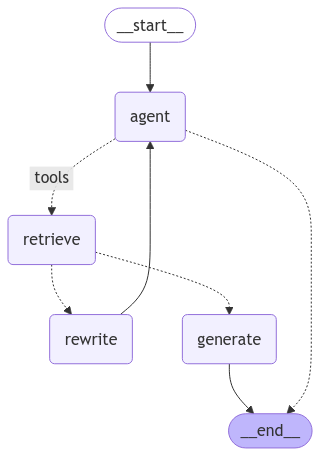

In [45]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [46]:
graph.invoke({"messages":"What is machine learning"})

---CALL AGENT---


{'messages': [HumanMessage(content='What is machine learning', additional_kwargs={}, response_metadata={}, id='cf4341ac-c138-4f12-8549-9609d655a586'),
  AIMessage(content='Machine learning is a method of teaching computers to make and improve predictions or take actions without being explicitly programmed to do so. It involves algorithms that can learn patterns from data and use this learning to make decisions or predictions on new data. Machine learning is a core component of artificial intelligence and is used in a wide range of applications, from recommendation systems and image recognition to natural language processing and autonomous driving. Would you like to know more about any specific aspect of machine learning?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 183, 'total_tokens': 277, 'completion_time': 0.47, 'prompt_time': 0.011521832, 'queue_time': 0.235460069, 'total_time': 0.481521832}, 'model_name': 'qwen-2.5-32b', 'sys

In [49]:
inputs={
    "messages": [
        ("user", "What is MAchine LEarning"),
    ]
}
for output in graph.stream(inputs):
    print(output)

---CALL AGENT---
{'agent': {'messages': [AIMessage(content='It seems like there might have been a small typo in your question. I assume you\'re asking about "Machine Learning." Machine Learning is a method of teaching computers to learn from data, without being explicitly programmed. It involves algorithms that can learn patterns from data and make predictions or decisions. Would you like more detailed information on specific aspects of Machine Learning, such as types of Machine Learning, applications, or the process of creating a Machine Learning model?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 185, 'total_tokens': 275, 'completion_time': 0.45, 'prompt_time': 0.011526565, 'queue_time': 0.22812938600000002, 'total_time': 0.461526565}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-31012478-b4c3-4b8e-b4ad-ae1b91f564a7-0', usage_metadata={'input_tokens': 18